<a href="https://colab.research.google.com/github/zhizhuoli1/Twitter-Gender-Prediction/blob/main/1%20-%20Data%20Preprocessing%20and%20EDA%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle: Twitter data
**website**: https://www.kaggle.com/crowdflower/twitter-user-gender-classification
<br /> <br />     
The dataset contains the following fields:
- **unitid**: a unique id for user
- **_golden**: whether the user was included in the gold standard for the model; TRUE or FALSE
- **unitstate**: state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)
- **trustedjudgments**: number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations
- **lastjudgment_at**: date and time of last contributor judgment; blank for gold standard observations
- **gender**: one of male, female, or brand (for non-human profiles)
- **gender:confidence**: a float representing confidence in the provided gender
- **profile_yn**: "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it
- **profile_yn:confidence**: confidence in the existence/non-existence of the profile
- **created**: date and time when the profile was created
- **description**: the user's profile description
- **fav_number**: number of tweets the user has favorited
- **gender_gold**: if the profile is golden, what is the gender?
- **link_color**: the link color on the profile, as a hex value
- **name**: the user's name
- **profileyngold**: whether the profile y/n value is golden
- **profileimage**: a link to the profile image
- **retweet_count**: number of times the user has retweeted (or possibly, been retweeted)
- **sidebar_color**: color of the profile sidebar, as a hex value
- **text**: text of a random one of the user's tweets
- **tweet_coord**: if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"
- **tweet_count**: number of tweets that the user has posted
- **tweet_created**: when the random tweet (in the text column) was created
- **tweet_id**: the tweet id of the random tweet
- **tweet_location**: location of the tweet; seems to not be particularly normalized
- **user_timezone**: the timezone of the user

## 1. Data Preprocessing 

### Data Cleaning pt.1

In [ ]:
%%capture
!pip install transformers
!pip install langdetect
!pip install lime
!pip install gensim
!pip install textblob
!pip install wordcloud
!pip install spacy
!python3 -m spacy download en  # run in terminal once
!pip install pyLDAvis
!pip install geopy

In [ ]:
%%capture
# Basic packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pickle

# For processing
import re
import nltk

# For w2v
import gensim
import gensim.downloader as gensim_api

# For BERT
import transformers

# Download relevant package within the nltk package
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# For language detection
import langdetect 

# For sentiment
from textblob import TextBlob

# For Bag of Words and feature selection
import lime
%matplotlib inline
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the csv file
path = '/content/drive/MyDrive/Twitter Gender Prediction/twitter.csv'
df = pd.read_csv(path, encoding='latin-1')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [ ]:
# Eliminate columns that have only unique value, and columns that are irrelevant. For exmaple, 'golden' variable means that someone at Crodflower
# Eliminated columns: '_unit_id','_golden','_unit_state','_last_judgment_at','created','profileimage', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'
# Eliminated 'tweet_coord', which indicates if the user has location turned on
# Eliminated columns: 'gender_gold', 'profile_yn_gold'

df = df.drop(['_unit_id','_golden','_unit_state','_last_judgment_at','profileimage','tweet_created','tweet_id','tweet_location','user_timezone','tweet_coord'],axis = 1)
df = df.drop(['gender_gold', 'profile_yn_gold'], axis = 1)
df.columns

Index(['_trusted_judgments', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'link_color', 'name', 'retweet_count', 'sidebar_color', 'text',
       'tweet_count'],
      dtype='object')

In [ ]:
# Drop the NaN rows in the column 'gender', because we cannot use NaN gender to predict and validate the results
df = df.dropna(subset=['gender'])

# Fill the empty rows in the 'description' column with an empty string
df.description = df.description.fillna('')

In [ ]:
# change the dtype of 'created' to datetime
df['created'] = pd.to_datetime(df['created'])


In [ ]:
# Get information on Null values in the DataFrame
# As we can see, there are still a lot of Null values in the 'description' column
df.isnull().sum()

_trusted_judgments       0
gender                   0
gender:confidence        0
profile_yn               0
profile_yn:confidence    0
created                  0
description              0
fav_number               0
link_color               0
name                     0
retweet_count            0
sidebar_color            0
text                     0
tweet_count              0
dtype: int64

In [ ]:
# Combine the 'description' (the user's profile description) and 'text' (text of a random one of the user's tweets)
# and create a new column named 'total_text'
# This column represent the text information on which we will build our analysis 

df['total_text'] = df['description'] +' '+ df['text']
df['total_text'][0]

'i sing my own rhythm. Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries https://t.co/NSybBmVjKZ'

In [ ]:
#change the dtype of 'total text' as string
df["total_text"] = df["total_text"].astype(str)

#### The above dataset can be used for general modeling and next, we will add some features to make the dataset for NLP analysis

### Data Cleaning pt.2

In [ ]:
# Import 'stopwords' from nltk 
from nltk.corpus import stopwords
lst_stopwords = stopwords.words('english')

# Define the function to clean the text
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub("[^a-zA-Z]", " ", text.lower().strip())
    # Tokenize (convert from string to list)
    lst_text = text.split()    
    # Remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]            
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]           
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]       
    # Convert back to string (from list)
    text = " ".join(lst_text)
    return text

In [ ]:
# Apply the function to the column 'total_text'

clean_text = (df["total_text"].apply(lambda x: preprocess_text(x, 
                                                              flg_stemm=False, 
                                                              flg_lemm=True, 
                                                              lst_stopwords=lst_stopwords)))

df["total_clean"] = clean_text
# Take a look at the cleaned text
df[['total_clean']].head()

,total_clean
0,sing rhythm robbie e responds critic win eddie...
1,author novel filled family drama romance felt ...
2,louis whining squealing absolutely adore louis...
3,mobile guy er shazam google kleiner perkins ya...
4,ricky wilson best frontman kaiser chief best b...


In [ ]:
# Return a tokenized copy of text, 
# using NLTK's recommended word tokenizer 
df['total_clean_list']= [nltk.word_tokenize(i) for i in df['total_clean']]

# Take a look at the tokenized text
df[['total_clean_list']].head()

,total_clean_list
0,"[sing, rhythm, robbie, e, responds, critic, wi..."
1,"[author, novel, filled, family, drama, romance..."
2,"[louis, whining, squealing, absolutely, adore,..."
3,"[mobile, guy, er, shazam, google, kleiner, per..."
4,"[ricky, wilson, best, frontman, kaiser, chief,..."


### Data Cleaning pt.3 (attempt)
- To create dummy variables for color columns
- However, it will result in 559+2986=3545 extra columns
- Thus, we decided not to implement the approach

In [ ]:
print("sidebar_color count:",len(pd.unique(df['sidebar_color'])),"; length of the dataframe:",len(df['sidebar_color']))
print("link_color count:",len(pd.unique(df['link_color'])),"; length of the dataframe:",len(df['sidebar_color']))

In [ ]:
# Create dummy variables for sidebar color

dummies_sidebar = pd.get_dummies(df.sidebar_color, prefix='sidebar_color')

print(dummies_sidebar.shape)
dummies_sidebar.head()

In [ ]:
# Create dummy variables for link color

dummies_link = pd.get_dummies(df.sidebar_color, prefix='link_color')

print(dummies_link.shape)
dummies_link.head()

## 2. Exploratory Data Analysis & Visualization

In [ ]:
# Make a copy of the cleaned DataFrame
data = df.copy()

### EDA - Gender 

In [ ]:
# Find out the unqiue value in the 'gender' column
data.gender.unique()

array(['male', 'female', 'brand', 'unknown'], dtype=object)

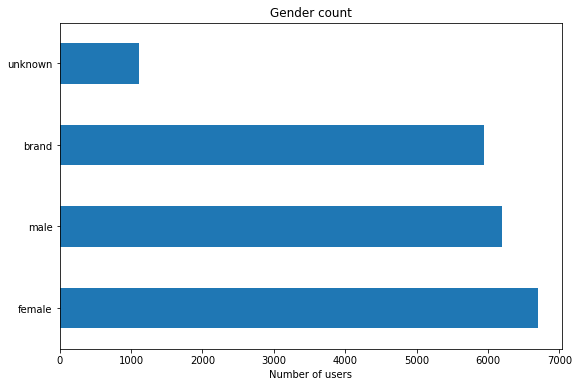

In [ ]:
# Plot the distribution of 'gender'
fig, ax = plt.subplots(figsize=(9,6)) 
pd.value_counts(data['gender']).plot(kind='barh')
plt.xlabel('Number of users')
plt.title('Gender count')
plt.show()

Four Categories - Female, Male, Brank, Unknown


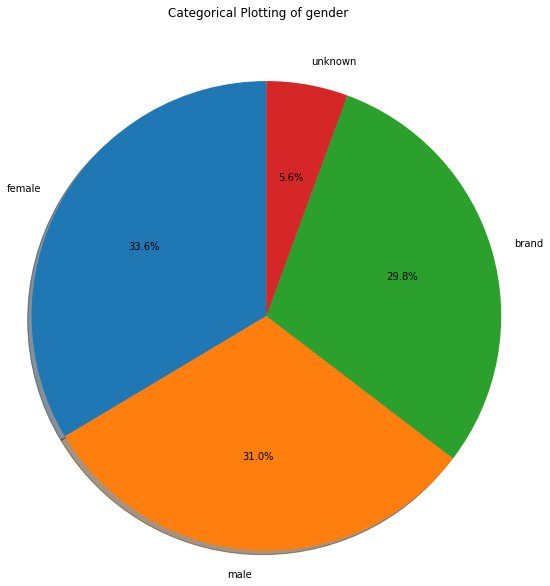

In [ ]:
# Visualize the gender of our dataset
fig, ax = plt.subplots(figsize=(9,9)) 
pd.value_counts(data['gender']).plot(kind="pie", startangle = 90, shadow = True, radius = 1.2, autopct = '%1.1f%%')
plt.suptitle('Categorical Plotting of gender')
plt.xlabel("")
plt.ylabel("")
plt.show() 

In [ ]:
# Function to plot line graph
def plot_x_per_y(legend1, legend2, legend3, y_per_x1, y_per_x2, y_per_x3, column1, column2, column3, column4):
    plot = plt.plot(y_per_x1[column1], [y for y in y_per_x1[column2]], label = legend1)
    plot = plt.plot(y_per_x2[column1], [y for y in y_per_x2[column3]], label = legend2)
    plot = plt.plot(y_per_x3[column1], [y for y in y_per_x3[column4]], label = legend3)
    return plot

def x_per_y(y_check1, y_check2, y_check3, x, y, column1, column2, column3, column4):
    x_now = pd.value_counts(x).sort_index()
    a, b, c = 0, 0, 0
    y_temp = []
    y_per_x = pd.DataFrame(columns = [column1, column2, column3, column4])
    for j in x_now.index:
        y_temp = (y.loc[x == j])
        for y_now in y_temp:
            if y_now == y_check1:
                a = a + 1
            if y_now == y_check2:
                b = b + 1
            if y_now == y_check3:
                c = c + 1
        y_per_x.loc[j] = [j] + [a] + [b] + [c]
        a, b, c = 0, 0, 0
    plot_x_per_y(y_check1, y_check2, y_check3, y_per_x, y_per_x, y_per_x, column1, column2, column3, column4)
    return

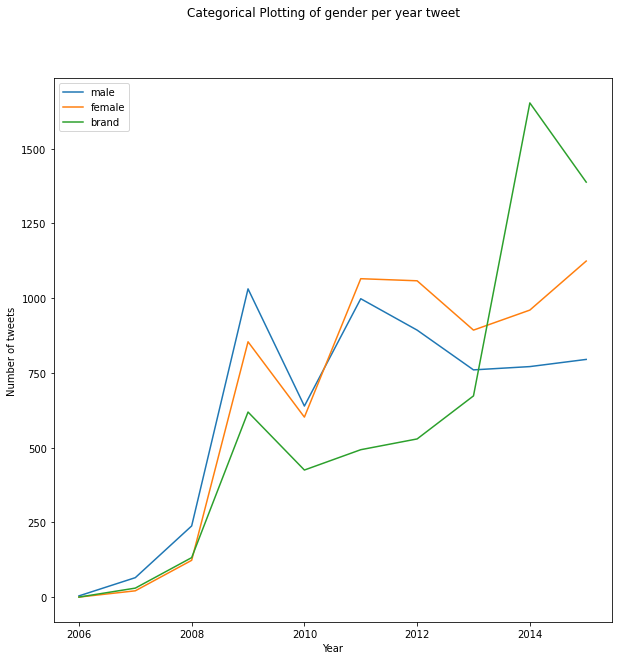

In [ ]:
# Plot the trend of each gender's number of tweets per year
fig, ax = plt.subplots(figsize=(10,10)) 
plot = x_per_y( 'male', 'female', 'brand', data['created'].dt.year, data['gender'], 'Year', 'male', 'female', 'brand')
plot = plt.suptitle('Categorical Plotting of gender per year tweet')
plot = plt.xlabel("Year")
plot = plt.ylabel("Number of tweets")
plot = plt.legend()
plot = plt.show() 
#not much difference between female and male, but there is increasing trend for brand to post more over time

### EDA - Length Analysis
- word count
- character count
- sentence count
- average word length
- average sentence length

In [ ]:
# Length Analysis
# word count: counts the number of tokens in the text (separated by a space)
data['word_count'] = data["text"].apply(lambda x: len(str(x).split(" ")))

# character count: sum the number of characters of each token
data['char_count'] = data["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

# sentence count: count the number of sentences (separated by a period)
data['sentence_count'] = data["text"].apply(lambda x: len(str(x).split(".")))

# average word length: sum of words length divided by the number of words (character count/word count)
data['avg_word_length'] = data['char_count'] / data['word_count']

# average sentence length: sum of sentences length divided by the number of sentences (word count/sentence count)
data['avg_sentence_lenght'] = data['word_count'] / data['sentence_count']

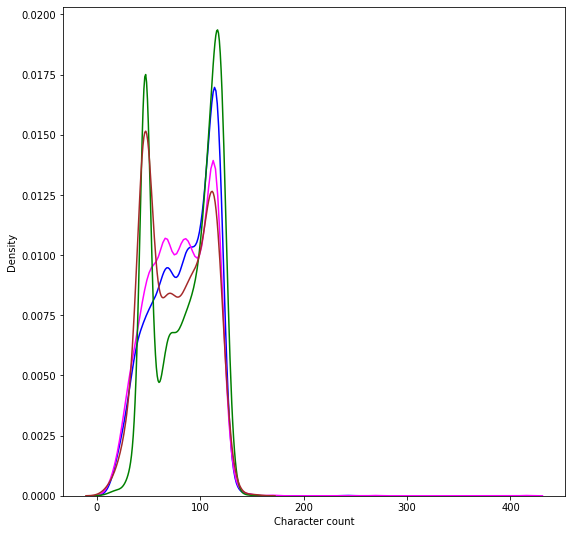

In [ ]:
# Visualize the result according to gender
fig, ax = plt.subplots(figsize=(9,9)) 
sns.kdeplot(data.char_count[data.gender=='male'], color = 'blue')
sns.kdeplot(data.char_count[data.gender=='female'], color = 'magenta')
sns.kdeplot(data.char_count[data.gender=='brand'], color = 'green')
sns.kdeplot(data.char_count[data.gender=='unknown'], color = 'brown')
plt.xlabel('Character count');

The character count are apparently shows the concentration around 20 characters and 120 characters. Female and male tend to have longer tweets, but brands tend to have splited style on short and long twitters.

### EDA - Language

In [ ]:
# Language detection and list the count
data['lang'] = data["text"].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")
pd.value_counts(data['lang'])

### EDA - Sentiment

In [ ]:
# Sentiment Analysis
data["sentiment"] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

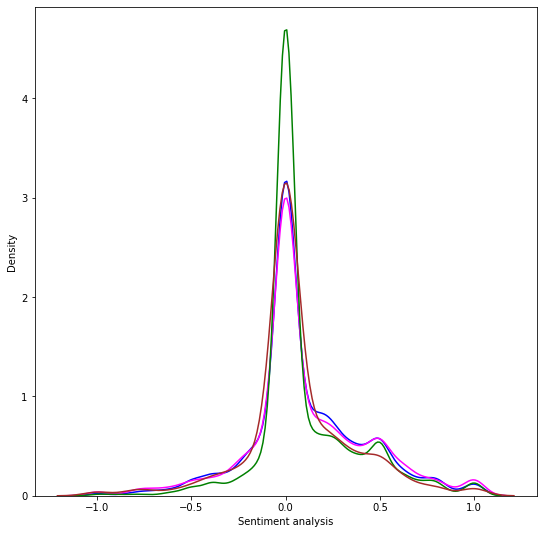

In [ ]:
# Visualize the result according to gender

fig, ax = plt.subplots(figsize=(9,9)) 
sns.kdeplot(data.sentiment[data.gender=='male'], color = 'blue')
sns.kdeplot(data.sentiment[data.gender=='female'], color = 'magenta')
sns.kdeplot(data.sentiment[data.gender=='brand'], color = 'green')
sns.kdeplot(data.sentiment[data.gender=='unknown'], color = 'brown')

plt.xlabel('Sentiment analysis')
plt.show()

###  EDA - The Most Popular Words by Gender

In [ ]:
# Make a copy of the 
eda_df = df.copy()

# Seperate the DataFrame by gender
male = eda_df[eda_df['gender'] == 'male']
female = eda_df[eda_df['gender'] == 'female']

# Create two long string which consist of the most popular tweets posted by each gender
male_words = pd.Series(' '.join(male['total_clean'].astype(str)).lower().split(" ")).value_counts()[:30]
female_words = pd.Series(' '.join(female['total_clean'].astype(str)).lower().split(" ")).value_counts()[:30]

print(male_words.head())
print('')
print(female_words.head())

co      2594
http    2479
love     618
like     534
get      470
dtype: int64

co      2479
http    2413
love     900
like     685
one      515
dtype: int64


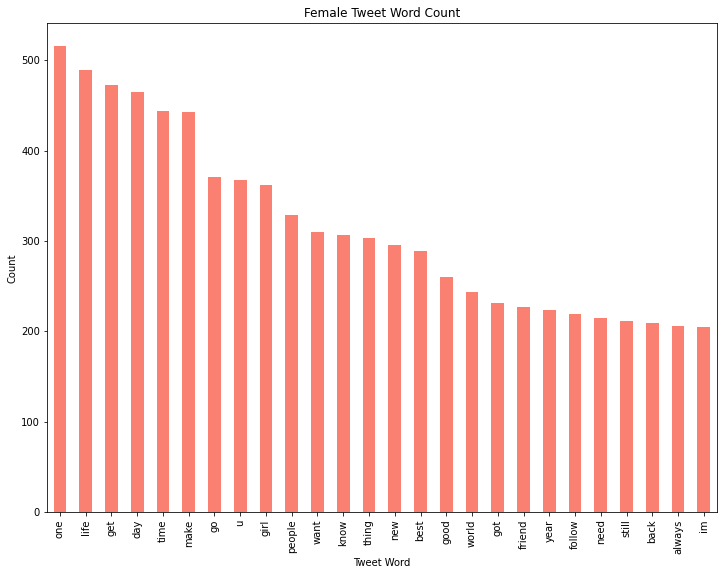

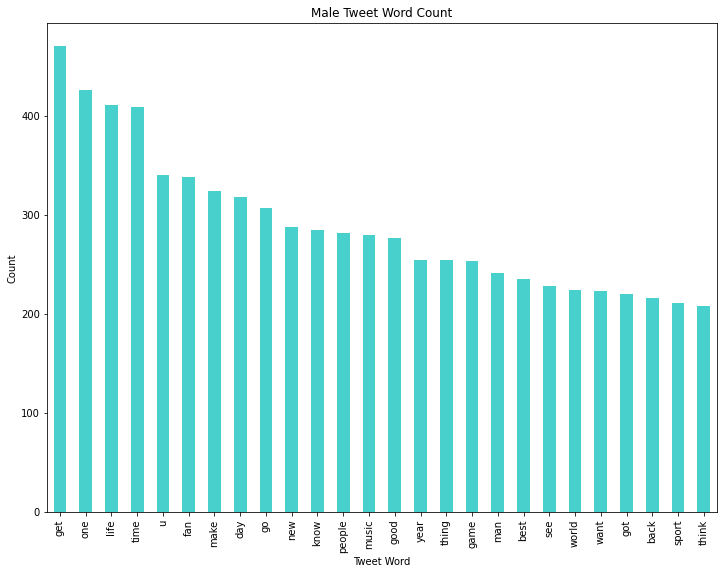

In [ ]:
# Since both of them start with co (from .com) and http, which do not offer valuable information
# we eliminate the first two words
male_words = male_words.iloc[2:]
female_words = female_words.iloc[2:]

# Plot the result - female
fig, ax = plt.subplots(figsize=(12,9)) 
fig.patch.set_facecolor('white')
plt.title("Female Tweet Word Count")
plt.xlabel("Tweet Word")
plt.ylabel("Count")
female_words.plot.bar(color="salmon")

# Plot the result - male
fig, ax = plt.subplots(figsize=(12,9)) 
fig.patch.set_facecolor('white')
plt.title("Male Tweet Word Count")
plt.xlabel("Tweet Word")
plt.ylabel("Count")
male_words.plot.bar(color="mediumturquoise")

plt.show()

### EDA - Retweet Count by Gender

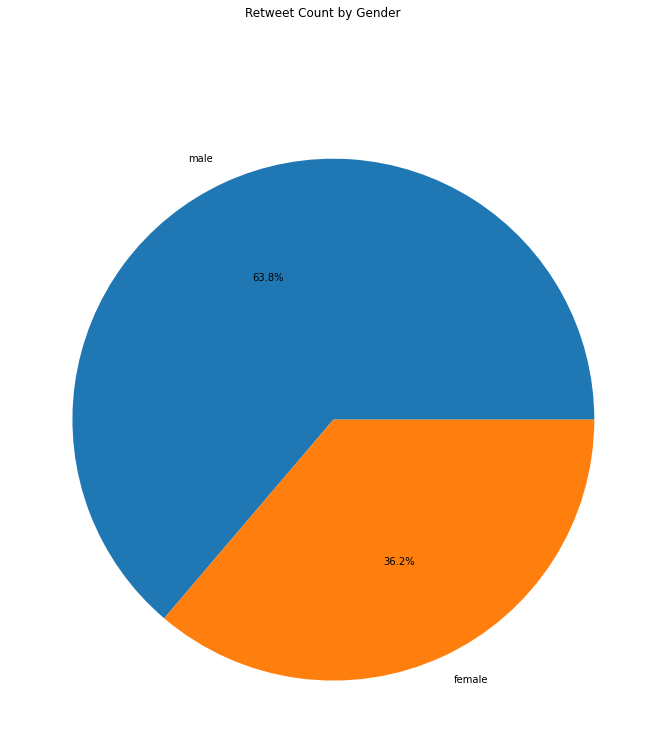

In [ ]:
male = eda_df[eda_df['gender'] == 'male']
male_retweet_count = np.sum(male.retweet_count)

female = eda_df[eda_df['gender'] == 'female']
female_retweet_count = np.sum(female.retweet_count)

fig, ax = plt.subplots(figsize=(12,12)) 
pd.Series(data=[male_retweet_count,female_retweet_count],index=['male','female']).plot(kind="pie",autopct = '%1.1f%%')
plt.suptitle('Retweet Count by Gender')
plt.xlabel("")
plt.ylabel("")
plt.show() 

### EDA - Link Color and Sidebar Color

In [ ]:
# Set the background color of seaborn plots
sns.set_style("darkgrid", {"axes.facecolor": "#F5ABB5"})

#### Popular Link Color - Female

The most popular Link Color used by female users are:
['0084B4' '9266CC' '000000' 'DD2E44' 'FF0000' 'ABB8C2' '3B94D9']


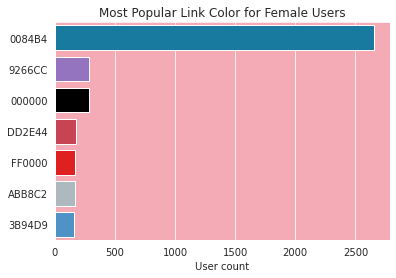

In [ ]:
female_top_link_color = eda_df[eda_df['gender'] == 'female']['link_color'].value_counts().head(7)
female_top_link_color_idx = female_top_link_color.index
female_top_color = female_top_link_color_idx.values

female_top_color[2] = '000000'
print('The most popular Link Color used by female users are:')
print(female_top_color)

l = lambda x: '#'+x
ax = sns.barplot(x = female_top_link_color, y = female_top_color, palette=list(map(l, female_top_color)))
ax.set(title='Most Popular Link Color for Female Users', xlabel='User count')
plt.show()

#### Popular Link Color - Male

The most popular Link Color used by female users are:
['0084B4' '9266CC' '000000' 'DD2E44' 'FF0000' 'ABB8C2' '3B94D9']


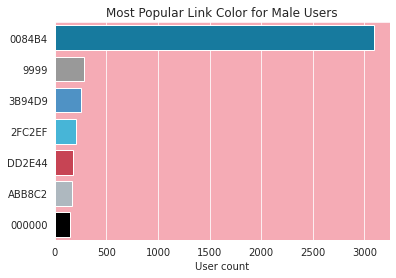

In [ ]:
male_top_link_color = eda_df[eda_df['gender'] == 'male']['link_color'].value_counts().head(7)
male_top_link_color_idx = male_top_link_color.index
male_top_color = male_top_link_color_idx.values

male_top_color[6] = '000000'
print('The most popular Link Color used by female users are:')
print(female_top_color)

l = lambda x: '#'+x
ax = sns.barplot(x = male_top_link_color, y = male_top_color, palette=list(map(l, male_top_color)))
ax.set(title='Most Popular Link Color for Male Users', xlabel='User count')
plt.show()

#### Popular Sidebar Color - Female

The most popular Sidebar Color used by female users are:
['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '65B0DA' '5ED4DC' 'CC3366']


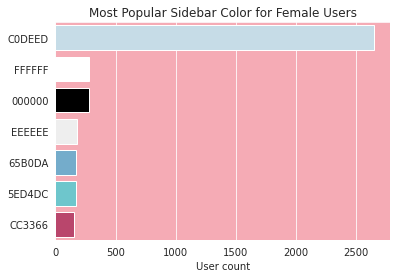

In [ ]:
female_top_sidebar_color = eda_df[eda_df['gender'] == 'female']['sidebar_color'].value_counts().head(7)
female_top_sidebar_color_idx = female_top_sidebar_color.index
female_top_color = female_top_sidebar_color_idx.values

female_top_color[2] = '000000'
print('The most popular Sidebar Color used by female users are:')
print(female_top_color)

l = lambda x: '#'+x
ax = sns.barplot(x = female_top_link_color, y = female_top_color, palette=list(map(l, female_top_color)))
ax.set(title='Most Popular Sidebar Color for Female Users', xlabel='User count')
plt.show()

#### Popular Sidebar Color - Male

The most popular Sidebar Color used by male users are:
['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '65B0DA' '5ED4DC' 'CC3366']


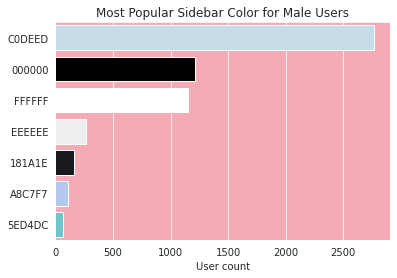

In [ ]:
male_top_sidebar_color = eda_df[eda_df['gender'] == 'male']['sidebar_color'].value_counts().head(7)
male_top_sidebar_color_idx = male_top_sidebar_color.index
male_top_color = male_top_sidebar_color_idx.values

male_top_color[1] = '000000'
print('The most popular Sidebar Color used by male users are:')
print(female_top_color)

l = lambda x: '#'+x
ax = sns.barplot(x = male_top_sidebar_color, y = male_top_color, palette=list(map(l, male_top_color)))
ax.set(title='Most Popular Sidebar Color for Male Users', xlabel='User count')
plt.show()

### EDA - Gender Confidence

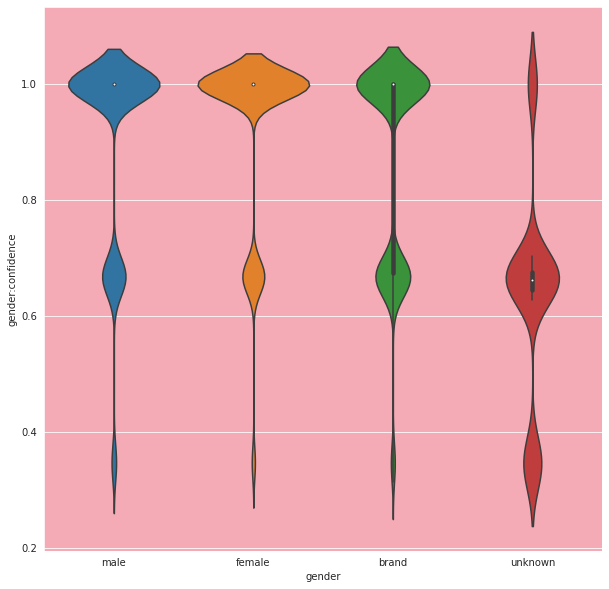

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

sns.violinplot(x = 'gender', y='gender:confidence', data=eda_df);

### EDA - Number of Tweets that Users 'favorite' by Gender

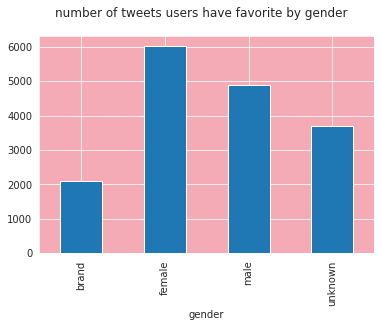

In [ ]:
num_tweet_fav = eda_df.groupby(['gender'])['fav_number'].mean()

num_tweet_fav.plot.bar()
plt.suptitle('number of tweets users have favorite by gender')
plt.show()

### EDA - Time Zone

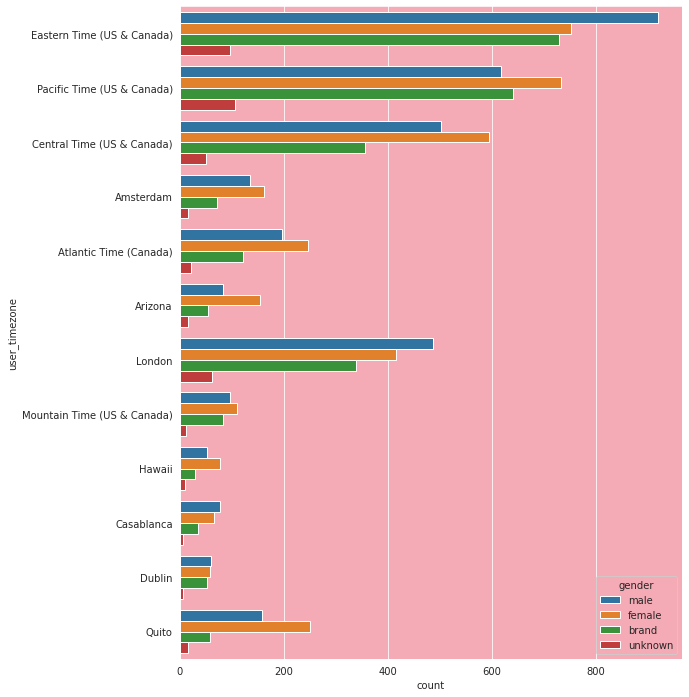

In [ ]:
con = pd.read_csv(path, encoding='latin-1')
con = con.dropna(subset=['gender'])

con['user_timezone'].value_counts()[:20]
con = con.groupby("user_timezone").filter(lambda x: len(x) >= 169)

#con.groupby(['gender']).count()['user_timezone'].plot(ax=ax)
fig, ax = plt.subplots(figsize=(9,12))
ax = sns.countplot(y="user_timezone", hue="gender", data=con)

### EDA - Profile Created Time

In [ ]:
data['created_datetime'] = pd.to_datetime(data['created'])
data['created_year'] = data['created_datetime'].dt.year
data['created_weekday'] = data['created_datetime'].dt.day_name()
data['created_month'] = data['created_datetime'].dt.month
data['created_hour'] = data['created_datetime'].dt.hour

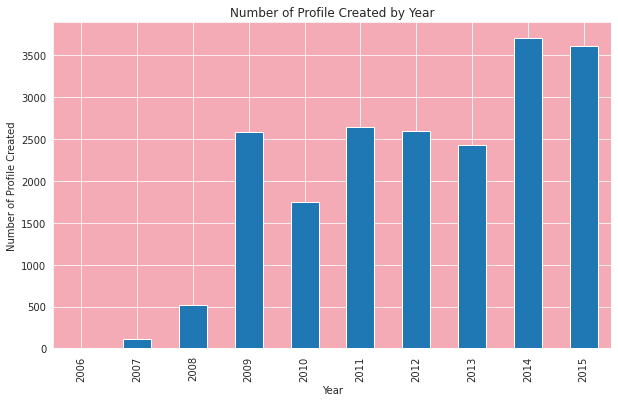

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

created_year = data.groupby(['created_year'])['text'].count().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Profile Created')
plt.title('Number of Profile Created by Year')
plt.show()

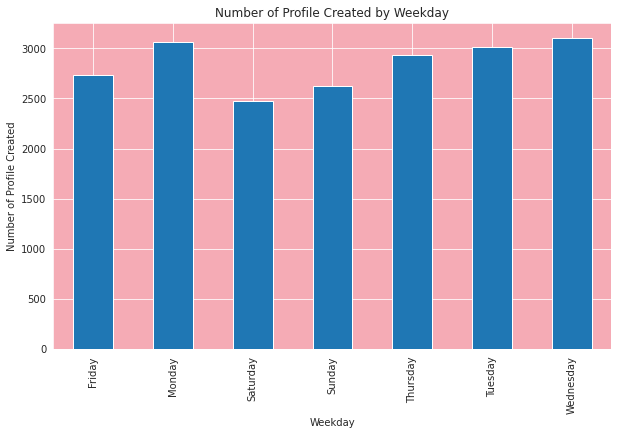

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

created_weekday = data.groupby(['created_weekday'])['text'].count().plot(kind='bar')
plt.xlabel('Weekday')
plt.ylabel('Number of Profile Created')
plt.title('Number of Profile Created by Weekday')
plt.show()

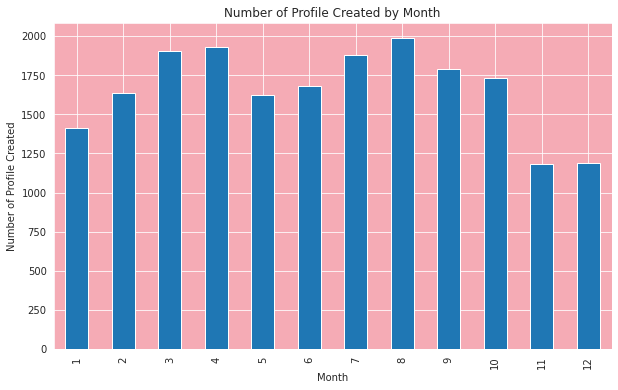

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

created_month = data.groupby(['created_month'])['text'].count().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Profile Created')
plt.title('Number of Profile Created by Month')
plt.show()

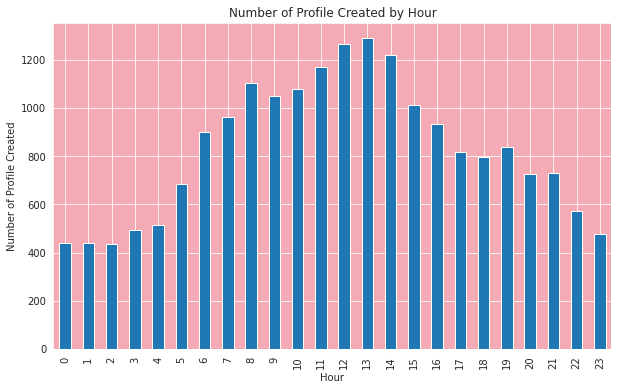

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

created_hour = data.groupby(['created_hour'])['text'].count().plot(kind='bar')
plt.xlabel('Hour')
plt.ylabel('Number of Profile Created')
plt.title('Number of Profile Created by Hour')
plt.show()

### EDA - Location

In [ ]:
from geopy.geocoders import Nominatim

# initialize Nominatim API  
geolocator = Nominatim(user_agent="geoapiExercises")

# Latitude & Longitude input 
Latitude = "25.594095"
Longitude = "85.137566"
  
location = geolocator.reverse(Latitude+","+Longitude) 
  
# Display 
print(location)

eda_lo = con.copy()
eda_lo = eda_lo.dropna(subset=['tweet_location'], axis = 0)

Patna, Patna Rural, Patna, Bihar, 800001, India


According to the latitude and longtitude, there are 4835 unique locations
The top 20 are shown below. It is evident that the latitude and longtitude information are not precise


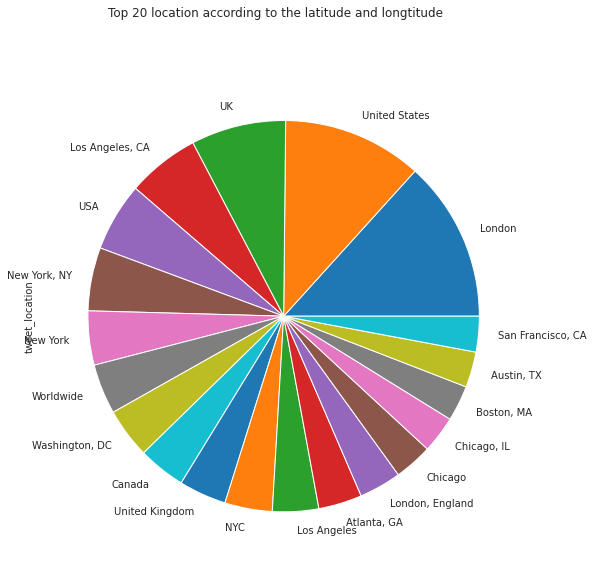

In [ ]:
print('According to the latitude and longtitude, there are',len(eda_lo.tweet_location.unique()),'unique locations')
print('The top 20 are shown below. It is evident that the latitude and longtitude information are not precise')

fig, ax = plt.subplots(figsize=(9,9))
eda_lo.tweet_location.value_counts()[:20].plot(kind='pie')

plt.suptitle('Top 20 location according to the latitude and longtitude')
plt.show()

In [ ]:
# The gensim package has a very convenient function that 
# returns the most similar words for any given word into the vocabulary

nlp.most_similar(['k-pop'],topn=10)

NameError: ignored

## PCA Analysis

In [ ]:
### Build a dataframe df_pca if we need to reduce the number of columns
df_pca = df.copy()

x = pd.get_dummies(df_pca[['_trusted_judgments', 'gender', 'gender:confidence', 'profile_yn', 'retweet_count', 'tweet_count']])


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
pcaaa = pd.DataFrame(data = principalComponents
             , columns = ['pca1', 'pca2','pca3','pca4','pca5'])

df_pca = pd.concat([gender,pcaaa], axis = 1)

In [ ]:
a= list(df.columns[0:14])
columns = ['pca1', 'pca2','pca3','pca4','pca5']
for i in columns:
    a.append(i)
a

['_trusted_judgments',
 'gender',
 'gender:confidence',
 'profile_yn',
 'profile_yn:confidence',
 'created',
 'description',
 'fav_number',
 'link_color',
 'name',
 'retweet_count',
 'sidebar_color',
 'text',
 'tweet_count',
 'pca1',
 'pca2',
 'pca3',
 'pca4',
 'pca5']

In [ ]:
df_pca.columns=a
df_pca #### This is our final dataframe with 5 pca values 

,_trusted_judgments,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,link_color,name,retweet_count,sidebar_color,text,tweet_count,pca1,pca2,pca3,pca4,pca5
0,3,male,1.0,yes,1.0,2013-12-05 01:48:00,i sing my own rhythm.,0,08C2C2,sheezy0,0,FFFFFF,Robbie E Responds To Critics After Win Against...,110964,72039.600662,-0.544258,-0.077057,-0.568428,0.615252
1,3,male,1.0,yes,1.0,2012-10-01 13:51:00,I'm the author of novels filled with family dr...,68,0084B4,DavdBurnett,0,C0DEED,ÛÏIt felt like they were my friends and I was...,7471,-31453.399338,-0.650619,-0.079764,-0.593273,0.562060
2,3,male,0.6625,yes,1.0,2014-11-28 11:30:00,louis whining and squealing and all,7696,ABB8C2,lwtprettylaugh,1,C0DEED,i absolutely adore when louis starts the songs...,5617,-33307.399338,-0.652743,0.920293,-0.601829,0.549433
3,3,male,1.0,yes,1.0,2009-06-11 22:39:00,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,douggarland,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693,-37231.399338,-0.656557,-0.079915,-0.594660,0.559090
4,3,female,1.0,yes,1.0,2014-04-16 13:23:00,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,3B94D9,WilfordGemma,0,0,Watching Neighbours on Sky+ catching up with t...,31462,-7462.399338,-0.626570,-0.081220,0.770871,0.181856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19948,259,female,1.0,yes,1.0,2015-08-05 21:16:00,(rp),302,0084B4,capuletrosa,0,C0DEED,"@lookupondeath ...Fine, and I'll drink tea too...",783,-38141.399601,255.341860,-0.037591,0.857934,0.100343
19949,248,male,1.0,yes,1.0,2012-08-15 21:17:00,"Whatever you like, it's not a problem at all. ...",2513,CFB929,BenNight41,0,0,Greg Hardy you a good player and all but don't...,13523,-25401.399590,244.355562,-0.037083,-0.501449,0.502251
19950,264,male,1.0,yes,1.0,2012-09-03 01:17:00,#TeamBarcelona ..You look lost so you should f...,50,0084B4,realuzzyfluxz,0,C0DEED,You can miss people and still never want to se...,26419,-12505.399606,260.368812,-0.033969,-0.492452,0.504770
19951,250,female,0.8489,yes,1.0,2012-11-06 23:46:00,Anti-statist; I homeschool my kids. Aspiring t...,70804,9266CC,argumatronic,0,0,@bitemyapp i had noticed your tendency to pee ...,56073,17148.600408,246.398663,-0.037658,0.863393,0.125234
